# Sistema de recomendação de imóveis - Parte 02
# Real state recomendation system  - Part 02

## Configurações básicas / Basic Configuration

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Alura Challange Semana 02") \
    .getOrCreate()

spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import functions as f

# Carregando os dados / Loading the data

In [ ]:
dados = spark.read.parquet('/content/drive/MyDrive/Alura/Challenge Data Science/parquet')

In [ ]:
dados.show(20, False)

+-----+----------+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-----------+----+------------------------+----------+----------+----------------+----------+-----------+
|andar|area_total|area_util|banheiros|caracteristicas                                                                                                                                   |id                                  |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|bairro                  |zona      |valor_iptu|valor_condominio|valor_tipo|valor_valor|
+-----+----------+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-

# Preparação dos dados / Data preparation

In [ ]:
dados.describe(['area_total', 'area_util']).show()

+-------+-----------------+------------------+
|summary|       area_total|         area_util|
+-------+-----------------+------------------+
|  count|            57368|             66562|
|   mean|938.1081264816622|116.73728253357771|
| stddev|84173.43322353484| 89.09094364150465|
|    min|                0|                10|
|    max|         15022793|              3456|
+-------+-----------------+------------------+



In [ ]:
dados = dados \
    .drop('area_total')

dados.show()

+-----+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+----------------+----------+-----------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|valor_iptu|valor_condominio|valor_tipo|valor_valor|
+-----+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+----------------+----------+-----------+
|    3|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|           Paciência|Zona Oeste|    [null]|           [245]|   [Venda]|      15000|
|    2|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|           Paciência|Zona Oes

In [ ]:
dados \
    .select('valor_tipo') \
    .groupBy('valor_tipo') \
    .count() \
    .show()

dados \
    .select('tipo_anuncio') \
    .groupBy('tipo_anuncio') \
    .count() \
    .show()

dados \
    .select('tipo_unidade') \
    .groupBy('tipo_unidade') \
    .count() \
    .show()

dados \
    .select('tipo_uso') \
    .groupBy('tipo_uso') \
    .count() \
    .show()

+----------------+-----+
|      valor_tipo|count|
+----------------+-----+
|[Venda, Aluguel]|  407|
|[Aluguel, Venda]|  214|
|         [Venda]|65941|
+----------------+-----+

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+



In [ ]:
dados = dados \
    .drop('valor_tipo') \
    .drop('tipo_anuncio') \
    .drop('tipo_unidade') \
    .drop('tipo_uso') \

dados.show()

+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|              bairro|      zona|valor_iptu|valor_condominio|valor_valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+
|    3|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|   1|           Paciência|Zona Oeste|    [null]|           [245]|      15000|
|    2|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|   1|           Paciência|Zona Oeste|       [0]|             [0]|      15000|
|    1|       41|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|  null|   1|           Guaratiba|Zona Oeste|       [0]|             [0]|      20000|
|    3|       43|        1|[

## Covertendo os tipos das colunas / Converting columns' types

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

In [ ]:
dados.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- valor_iptu: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- valor_condominio: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- valor_valor: integer (nullable = true)



In [ ]:
dados = dados \
    .withColumn('andar', dados['andar'].cast(IntegerType())) \
    .withColumn('area_util', dados['area_util'].cast(DoubleType())) \
    .withColumn('valor_iptu', dados['valor_iptu'][0].cast(DoubleType())) \
    .withColumn('valor_condominio', dados['valor_condominio'][0].cast(DoubleType())) \
    .withColumn('valor_valor', dados['valor_valor'].cast(DoubleType())) \
    
dados.printSchema()

root
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- valor_iptu: double (nullable = true)
 |-- valor_condominio: double (nullable = true)
 |-- valor_valor: double (nullable = true)



In [ ]:
dados.select('andar').groupby('andar').count().orderBy('andar').show(60)

+-----+-----+
|andar|count|
+-----+-----+
|    0|41176|
|    1| 3207|
|    2| 3694|
|    3| 3552|
|    4| 2711|
|    5| 2417|
|    6| 1851|
|    7| 1518|
|    8| 1318|
|    9|  838|
|   10| 1262|
|   11|  524|
|   12|  522|
|   13|  332|
|   14|  208|
|   15|  417|
|   16|  181|
|   17|  229|
|   18|  119|
|   19|   57|
|   20|  131|
|   21|   88|
|   22|   67|
|   23|   21|
|   24|    9|
|   25|   20|
|   26|    8|
|   27|    1|
|   28|    6|
|   29|    1|
|   30|    3|
|   32|    2|
|   37|    1|
|   39|    1|
|   40|    2|
|   41|    1|
|   42|    1|
|   43|    1|
|   45|    2|
|   47|    3|
|   48|    1|
|   50|   31|
|   70|    2|
|   99|    6|
|  102|    1|
|  123|    5|
|  150|    1|
|  280|    1|
|  300|    1|
|  345|    1|
|  504|    1|
|  703|    1|
| 1234|    8|
+-----+-----+



In [ ]:
dados = dados \
    .select("*") \
    .where("andar <= 50") \

dados.select('andar').groupby('andar').count().orderBy('andar').show(60)

+-----+-----+
|andar|count|
+-----+-----+
|    0|41176|
|    1| 3207|
|    2| 3694|
|    3| 3552|
|    4| 2711|
|    5| 2417|
|    6| 1851|
|    7| 1518|
|    8| 1318|
|    9|  838|
|   10| 1262|
|   11|  524|
|   12|  522|
|   13|  332|
|   14|  208|
|   15|  417|
|   16|  181|
|   17|  229|
|   18|  119|
|   19|   57|
|   20|  131|
|   21|   88|
|   22|   67|
|   23|   21|
|   24|    9|
|   25|   20|
|   26|    8|
|   27|    1|
|   28|    6|
|   29|    1|
|   30|    3|
|   32|    2|
|   37|    1|
|   39|    1|
|   40|    2|
|   41|    1|
|   42|    1|
|   43|    1|
|   45|    2|
|   47|    3|
|   48|    1|
|   50|   31|
+-----+-----+



## Tratamento de dados faltantes / Dealing with missing data

In [ ]:
dados \
    .select(f.col('caracteristicas').alias('nulos')) \
    .where(f.size(f.col('caracteristicas')) < 1) \
    .show()

+-----+
|nulos|
+-----+
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
|   []|
+-----+
only showing top 20 rows



In [ ]:
dados = dados.withColumn(
    'caracteristicas',
    f.when(f.size(f.col('caracteristicas')) == 0, None) \
    .otherwise(f.col('caracteristicas'))
) \

dados\
    .select(f.col('caracteristicas').alias('nulos')) \
    .where(f.size(f.col('caracteristicas')) < 1) \
    .show()


+-----+
|nulos|
+-----+
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
| null|
+-----+
only showing top 20 rows



In [ ]:
dados = dados \
    .select("*") \
    .na.fill(0)

dados.show()

+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|              bairro|      zona|valor_iptu|valor_condominio|valor_valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+
|    3|     43.0|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|     0|   1|           Paciência|Zona Oeste|       0.0|           245.0|    15000.0|
|    2|     42.0|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|     0|   1|           Paciência|Zona Oeste|       0.0|             0.0|    15000.0|
|    1|     41.0|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|     0|   1|           Guaratiba|Zona Oeste|       0.0|             0.0|    20000.0|
|    3|     43.0|        1|[

## Criação de variáveis Dummy / Dummy variables creation

In [ ]:
dados \
  .select('zona')\
  .groupBy('zona')\
  .count()\
  .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11895|
|  Zona Oeste|32954|
|Zona Central| 1143|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



In [ ]:
dados = dados \
    .select("*") \
    .where("zona != ''")

dados \
  .select('zona')\
  .groupBy('zona')\
  .count()\
  .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11895|
|  Zona Oeste|32954|
|Zona Central| 1143|
|    Zona Sul|20531|
+------------+-----+



In [ ]:
zona = dados \
    .select("*") \
    .groupBy("id") \
    .pivot("zona") \
    .agg(f.lit(1)) \
    .na.fill(0) \
    
zona.show()

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
|ece1e671-cb4d-48a...|           1|         0|         0|       0|
|3521e03b-0815-4aa...|           0|         0|         0|       1|
|03a386b6-7ab8-4ef...|           0|         0|         1|       0|
|107507e0-f075-47e...|           0|         0|         1|       0|
|c7e56e3a-a2b2-48a...|           0|         0|         1|       0|
|b37a2a08-d3c6-489...|           0|         1|         0|       0|
|a4b88c04-2655-414...|           0|         0|         1|     

In [ ]:
caract = dados \
    .select('id', f.explode(dados['caracteristicas']).alias('caract')) \
    .groupBy("id") \
    .pivot("caract") \
    .agg(f.lit(1)) \
    .na.fill(0)

caract.show()

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|                 1|            1|                 0|       0|      1|         1|           0|                0|              1|
|afecddff-f4cc-4ab...|       1|               

In [ ]:
dataset = dados \
    .join(zona, 'id', how='inner') \
    .join(caract, 'id', how='inner')

dataset.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|      zona|valor_iptu|valor_condominio|valor_valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+----------------+-----------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+---------

In [ ]:
dataset = dataset \
    .drop('bairro') \
    .drop('caracteristicas') \
    .drop('zona')

dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = false)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- valor_iptu: double (nullable = false)
 |-- valor_condominio: double (nullable = false)
 |-- valor_valor: double (nullable = false)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable = true)
 |-- Sa

## Salvando Dataset em Parquet / Saving the Dataset in Parquet

In [ ]:
dataset.write.parquet('/content/drive/MyDrive/Alura/Challenge Data Science/Dataset', mode='overwrite')

## Vetorização dos Dados / Data vetorization

In [ ]:
from pyspark.ml.feature import VectorAssembler


In [ ]:
dataset = dataset.withColumnRenamed('valor_valor', 'label')

In [ ]:
dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'valor_iptu',
 'valor_condominio',
 'label',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [ ]:
X = [
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'valor_iptu',
 'valor_condominio',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas'
]

In [ ]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [ ]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [ ]:
dataset_prep.show(10, False)

+-------------------------------------------------------------------------------------------------+---------+
|features                                                                                         |label    |
+-------------------------------------------------------------------------------------------------+---------+
|(22,[1,2,3,4,5,6,7,11,16],[410.0,3.0,4.0,1.0,1.0,5780.0,3300.0,1.0,1.0])                         |4600000.0|
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,600.0,500.0,1.0,1.0,1.0,1.0,1.0])        |360000.0 |
|(22,[1,2,3,4,5,10,14,16,17],[148.0,4.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0])                             |1200000.0|
|(22,[1,2,3,6,7,11,16],[104.0,1.0,2.0,272.0,1010.0,1.0,1.0])                                      |750000.0 |
|(22,[1,2,3,5,6,7,11,16],[71.0,2.0,2.0,1.0,360.0,1312.0,1.0,1.0])                                 |1025000.0|
|[3.0,115.0,2.0,3.0,0.0,0.0,3831.0,1904.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0]|1100000.0|
|[0.0,65.0

## Análise de correlação / Correlation analysis

In [ ]:
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [ ]:
correlacao = correlacao[0][0]
correlacao

DenseMatrix(22, 22, [1.0, 0.0454, 0.0007, -0.015, 0.0078, 0.0164, -0.0018, 0.0206, ..., 0.5441, 0.351, 0.1644, 0.5457, 0.661, 0.3079, 0.2208, 1.0], False)

In [ ]:
correlacao = correlacao.toArray()
correlacao

array([[ 1.00000000e+00,  4.53945279e-02,  7.32994965e-04,
        -1.49671620e-02,  7.83491213e-03,  1.64225464e-02,
        -1.75943517e-03,  2.05743315e-02,  1.24475384e-01,
        -1.17327404e-02, -4.92135265e-02,  2.72769998e-02,
         1.44923748e-01,  3.09950145e-01,  6.25600240e-02,
         2.59318193e-01,  1.70672339e-01,  5.15691349e-02,
         9.83702406e-02,  3.47514900e-01,  3.19359469e-01,
         1.12751513e-01],
       [ 4.53945279e-02,  1.00000000e+00,  6.86365294e-01,
         6.74025982e-01,  6.32229678e-01,  4.91547759e-01,
         2.23128739e-02,  4.52494759e-02, -1.07567045e-01,
        -1.70825299e-01,  1.33337442e-01,  2.86151365e-02,
         6.86731907e-03, -1.10265991e-02, -2.47009419e-02,
        -1.02579663e-02,  3.33778540e-02,  2.83750410e-02,
        -1.43839256e-02, -2.49914634e-02,  2.34454973e-03,
        -2.84834813e-02],
       [ 7.32994965e-04,  6.86365294e-01,  1.00000000e+00,
         6.67102120e-01,  7.41708097e-01,  4.58673748e-01,
    

In [ ]:
correlacao_df = pd.DataFrame(correlacao, columns=X, index=X)
correlacao_df

,andar,area_util,banheiros,quartos,suites,vaga,valor_iptu,valor_condominio,Zona Central,Zona Norte,...,Academia,Animais permitidos,Churrasqueira,Condomínio fechado,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas
andar,1.000000,0.045395,0.000733,-0.014967,0.007835,0.016423,-0.001759,0.020574,0.124475,-0.011733,...,0.144924,0.309950,0.062560,0.259318,0.170672,0.051569,0.098370,0.347515,0.319359,0.112752
area_util,0.045395,1.000000,0.686365,0.674026,0.632230,0.491548,0.022313,0.045249,-0.107567,-0.170825,...,0.006867,-0.011027,-0.024701,-0.010258,0.033378,0.028375,-0.014384,-0.024991,0.002345,-0.028483
banheiros,0.000733,0.686365,1.000000,0.667102,0.741708,0.458674,0.014018,0.026973,-0.132874,-0.166191,...,0.084888,-0.043912,0.039867,-0.022670,0.061514,0.111763,0.069578,-0.056445,-0.032844,0.056521
quartos,-0.014967,0.674026,0.667102,1.000000,0.596361,0.447123,0.017933,0.022134,-0.168245,-0.124345,...,0.073803,-0.026786,0.076122,-0.001187,0.036701,0.104050,0.096569,-0.028293,-0.019638,0.076557
suites,0.007835,0.632230,0.741708,0.596361,1.000000,0.464507,0.011211,0.028684,-0.110733,-0.213829,...,0.244658,0.028289,0.175059,0.115568,0.084213,0.273062,0.179209,0.046709,0.059597,0.159933
vaga,0.016423,0.491548,0.458674,0.447123,0.464507,1.000000,0.011947,0.024859,-0.104251,-0.108690,...,0.136522,0.009028,0.125251,0.057020,0.023075,0.174777,0.127694,0.004958,0.020255,0.127079
valor_iptu,-0.001759,0.022313,0.014018,0.017933,0.011211,0.011947,1.000000,0.205853,-0.003939,-0.008813,...,-0.000154,-0.006407,-0.007983,-0.011220,0.001215,-0.001889,-0.003612,-0.005606,-0.009097,-0.003527
valor_condominio,0.020574,0.045249,0.026973,0.022134,0.028684,0.024859,0.205853,1.000000,-0.004729,-0.010117,...,0.011724,0.009543,0.001435,0.008873,0.009656,0.006301,0.005927,0.008868,0.002293,0.005218
Zona Central,0.124475,-0.107567,-0.132874,-0.168245,-0.110733,-0.104251,-0.003939,-0.004729,1.000000,-0.063245,...,0.040069,0.053982,-0.010237,0.044770,0.033223,0.003558,-0.016174,0.047389,0.040073,-0.002798
Zona Norte,-0.011733,-0.170825,-0.166191,-0.124345,-0.213829,-0.108690,-0.008813,-0.010117,-0.063245,1.000000,...,-0.136816,-0.019122,-0.050686,-0.101144,-0.017900,-0.157157,-0.032229,-0.077880,-0.027313,-0.008830


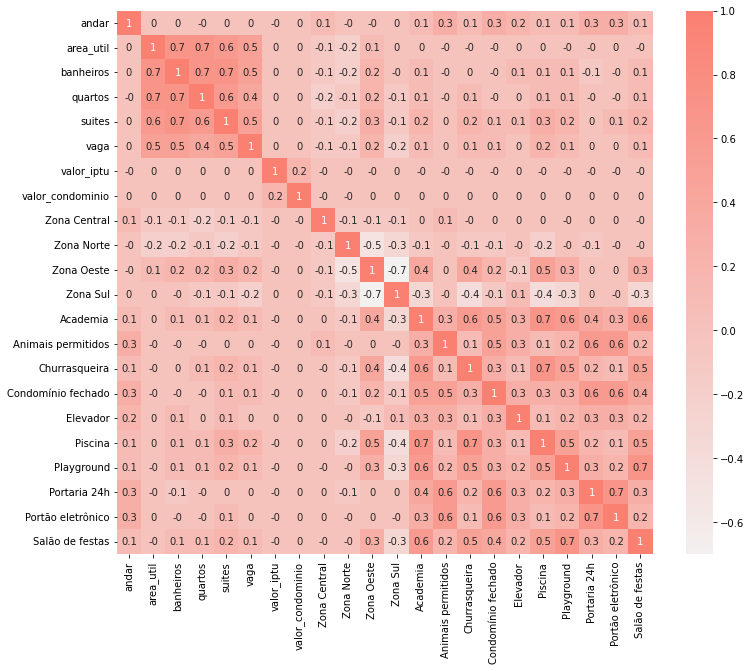

In [ ]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(correlacao_df.round(1), annot=True, cmap=paleta)

# Regressão Linear / Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=202)

In [ ]:
treino.count()

37704

In [ ]:
teste.count()

16096

In [ ]:
lr = LinearRegression()

In [ ]:
modelo_lr = lr.fit(treino)

In [ ]:
prev_lr_treino = modelo_lr.transform(treino)

In [ ]:
prev_lr_treino.show()

+--------------------+---------+-------------------+
|            features|    label|         prediction|
+--------------------+---------+-------------------+
|(22,[0,1,2,3,4,5,...| 262000.0|  701385.0998071819|
|(22,[0,1,2,3,4,5,...| 917000.0|  694952.0608767555|
|(22,[0,1,2,3,4,5,...| 560000.0|  1154375.224931684|
|(22,[0,1,2,3,4,5,...| 630000.0| 1329935.0520376062|
|(22,[0,1,2,3,4,5,...| 816000.0|   728392.349584006|
|(22,[0,1,2,3,4,5,...| 996000.0|  704417.8327955608|
|(22,[0,1,2,3,4,5,...| 420000.0| 284762.58932019863|
|(22,[0,1,2,3,4,5,...|1485400.0|  943413.9796319213|
|(22,[0,1,2,3,4,5,...|  99000.0|-137280.20740069245|
|(22,[0,1,2,3,4,5,...| 620000.0| 40096.620267859435|
|(22,[0,1,2,3,4,5,...| 750000.0|  7631.653241595961|
|(22,[0,1,2,3,4,5,...| 690000.0| 522278.18565913825|
|(22,[0,1,2,3,4,5,...| 897000.0| 1467899.1031139893|
|(22,[0,1,2,3,4,5,...| 290000.0|  691009.6561620533|
|(22,[0,1,2,3,4,5,...| 480000.0|  288748.3270706856|
|(22,[0,1,2,3,4,5,...| 570000.0|   920248.3037

In [ ]:
print(modelo_lr.summary.r2)
print(modelo_lr.summary.rootMeanSquaredError)

0.6789199941314505
852462.9710229166


In [ ]:
print(modelo_lr.evaluate(teste).r2)
print(modelo_lr.evaluate(teste).rootMeanSquaredError)

0.6522044138744197
871523.1435324732


## Criando modelos com validação cruzada e busca por malha / Creating models with cross validations and grid search

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

### Decision tree

In [ ]:
dtr = DecisionTreeRegressor()
dtr_grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10])\
    .addGrid(dtr.maxBins, [10, 32, 45])\
    .build()
dtr_evaluator = RegressionEvaluator()

In [ ]:
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=dtr_grid,
    evaluator=dtr_evaluator,
    numFolds=5
)

In [ ]:
modelo_dtr = dtr_cv.fit(treino)

In [ ]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [ ]:
print('Decision Tree Regression')
print("="*30)
print("R²: %f" % dtr_evaluator.evaluate(previsoes_dtr_teste, {dtr_evaluator.metricName: "r2"}))
print("RMSE: %f" % dtr_evaluator.evaluate(previsoes_dtr_teste, {dtr_evaluator.metricName: "rmse"}))



Decision Tree Regression
R²: 0.761379
RMSE: 721889.984076


### Random Forest

In [ ]:
rfr = RandomForestRegressor()
rfr_grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30])\
    .addGrid(rfr.maxDepth, [5, 10])\
    .addGrid(rfr.maxBins, [10, 32, 45])\
    .build()
rfr_evaluator = RegressionEvaluator()

In [ ]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=rfr_grid,
    evaluator=rfr_evaluator,
    numFolds=5
)

In [ ]:
modelo_rfr = rfr_cv.fit(treino)

In [ ]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [ ]:
print('Random Forest Regression')
print("="*30)
print("R²: %f" % rfr_evaluator.evaluate(previsoes_rfr_teste, {rfr_evaluator.metricName: "r2"}))
print("RMSE: %f" % rfr_evaluator.evaluate(previsoes_rfr_teste, {rfr_evaluator.metricName: "rmse"}))



Random Forest Regression
R²: 0.840613
RMSE: 589988.328365


### Gradient-Boosted Tree

In [ ]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
gbtr = GBTRegressor()
gbtr_grid = ParamGridBuilder() \
    .addGrid(gbtr.maxIter, [5, 10, 15])\
    .addGrid(gbtr.maxDepth, [5, 10])\
    .addGrid(gbtr.maxBins, [10, 32, 45])\
    .build()
gbtr_evaluator = RegressionEvaluator()

In [ ]:
gbtr_cv = CrossValidator(
    estimator=gbtr,
    estimatorParamMaps=gbtr_grid,
    evaluator=gbtr_evaluator,
    numFolds=5
)

In [ ]:
gbtr_model = gbtr_cv.fit(treino)

In [ ]:
previsoes_gbtr_teste = gbtr_model.transform(teste)

In [ ]:
print('Gradient-Boosted Tree Regression')
print("="*30)
print("R²: %f" % gbtr_evaluator.evaluate(previsoes_gbtr_teste, {gbtr_evaluator.metricName: "r2"}))
print("RMSE: %f" % gbtr_evaluator.evaluate(previsoes_gbtr_teste, {gbtr_evaluator.metricName: "rmse"}))



Gradient-Boosted Tree Regression
R²: 0.793372
RMSE: 671755.711183
